In [1]:
!pip install muspy

In [2]:
import muspy
import torch
from torch.utils.data import DataLoader

#need create file "music_data/processed" first
data_path = "./music_data"
pr_data_path = "./music_data/processed/"

# Download and extract the dataset
jsb = muspy.datasets.JSBChoralesDataset(data_path, download_and_extract=True)

for i, music in enumerate(jsb):
    music.adjust_resolution(4)
    music.save(f"{pr_data_path}{i}.json")

psd = muspy.MusicDataset(pr_data_path)

dataset = psd.to_pytorch_dataset(representation="pianoroll")

3096576it [00:03, 811167.52it/s]                                                                                       


Successfully downloaded source : C:\Users\USER\Desktop\aa\ai project\music_data\JSB Chorales.zip .
Extracting archive : C:\Users\USER\Desktop\aa\ai project\music_data\JSB Chorales.zip ...
Successfully extracted archive : C:\Users\USER\Desktop\aa\ai project\music_data .


In [3]:
data = list()
# use Dataloader extract data
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
cnt=0

condInput = list()
genInput = list()
bar = 1

for it in dataloader:
    it = it.squeeze(0)
    condInput.append(torch.zeros(128, 16*bar, dtype=int))
    for i in range(it.shape[0]//(16*bar)):
        piece = torch.transpose(it[16*bar*i:16*bar*(i+1), :], 0, 1)
        piece = piece.int()
        condInput.append(piece)
        genInput.append(piece)
    condInput.pop()
    cnt+=1
print(len(condInput), len(genInput))

11418 11418


In [4]:
#delete silent bars
cInput = list()
gInput = list()
for _ in range(len(condInput)):
    if condInput[_].sum() == 0 or genInput[_].sum() == 0:
        continue;
    i = condInput[_].numpy()
    i = i / i.max()
    i = torch.from_numpy(i)
    i = i.type(torch.IntTensor)
    cInput.append(i)
    
    i = genInput[_].numpy()
    i = i / i.max()
    i = torch.from_numpy(i)
    i = i.type(torch.IntTensor)
    gInput.append(i)
    
print(len(cInput))

10649


In [5]:
from torch.utils.data import Dataset

#define custom Pytorch dataset
#G : data use to generate (goes to conditioner in generator)
#I : data to identify generator (goes to discriminator)

class ProcessedDataset(Dataset):
    def __init__(self, G, I):
        self.Gdata = G
        self.Idata = I
    def __len__(self):
        return len(self.Gdata)
    def __getitem__(self, idx):
        return self.Gdata[idx], self.Idata[idx]

ps_data = ProcessedDataset(cInput[:10240], gInput[:10240])
#save data
torch.save(ps_data, "./GandI_len128_10240.pt")

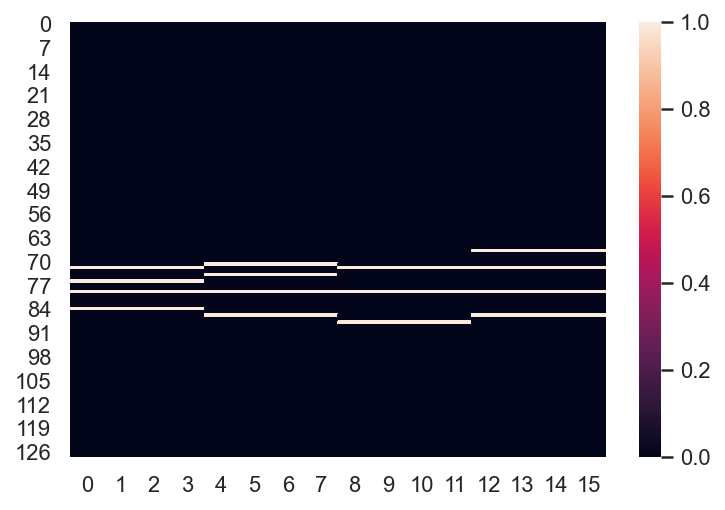

In [6]:
#ckeck data is correct
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
ax = sns.heatmap(ps_data[0][0])